### INTRODUCTION

**About Dataset**

This dataset source from [kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

### IMPORT LIBRARY

In [1]:
# Basic modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### LOAD DATA

In [2]:
df = pd.read_csv('dataset/Tweets.csv')

In [3]:
# Get the shape of dataset (total column and total rows)
df.shape

(14640, 15)

In [4]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The column name "airline_sentiment" is the label of this dataset and we will take the data from dataset with "neutral" and "negative" label only.

In [6]:
df_new = df.loc[df['airline_sentiment'].isin(["neutral","negative"])]
df_new['airline_sentiment'].unique()

array(['neutral', 'negative'], dtype=object)

In [7]:
print(f"The original dataset consist of {df.shape[0]} rows and the dataset that we will be use here is {df_new.shape[0]} rows which means the total of {df.shape[0]-df_new.shape[0]} rows will not be used for training.")

The original dataset consist of 14640 rows and the dataset that we will be use here is 12277 rows which means the total of 2363 rows will not be used for training.


In [8]:
# Display missing value rate on each column
missing = df_new.isnull().sum()/df_new.shape[0]*100
df_new.isnull().sum()


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   3099
negativereason_confidence        2085
airline                             0
airline_sentiment_gold          12242
name                                0
negativereason_gold             12245
retweet_count                       0
text                                0
tweet_coord                     11433
tweet_created                       0
tweet_location                   4104
user_timezone                    4141
dtype: int64

In [9]:
# Get only the column of text and the label of data.
clean_data = df_new[['airline_sentiment','text']]
clean_data.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
2,neutral,@VirginAmerica I didn't today... Must mean I n...


<AxesSubplot: xlabel='airline_sentiment', ylabel='count'>

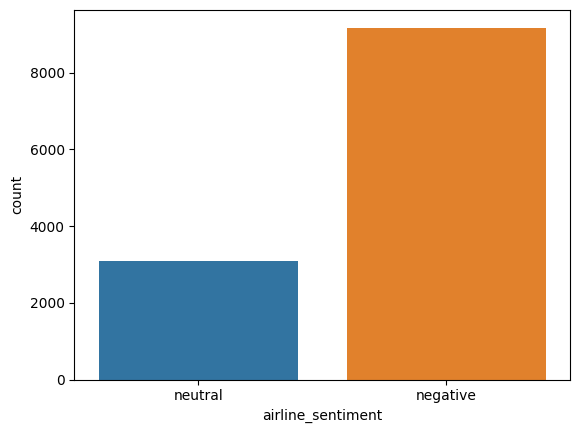

In [10]:
sns.countplot(x='airline_sentiment', data = clean_data)

The data we have is an imbalance data. The total data of negative sentiment is 50% higher than the neutral one.

In [12]:
neutral_sentiment_df = clean_data[clean_data['airline_sentiment'] == 'neutral']
negative_sentiment_index = clean_data[clean_data['airline_sentiment'] == 'negative'].sample(neutral_sentiment_df.shape[0]).index
negative_sentiment_df = clean_data.loc[negative_sentiment_index]
balanced_dataset_df = neutral_sentiment_df.append(negative_sentiment_df, ignore_index=True)

/var/folders/_x/9qpm23j50mq38rh_8k9x38180000gn/T/ipykernel_13585/496771188.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_dataset_df = neutral_sentiment_df.append(negative_sentiment_df, ignore_index=True)


<AxesSubplot: >

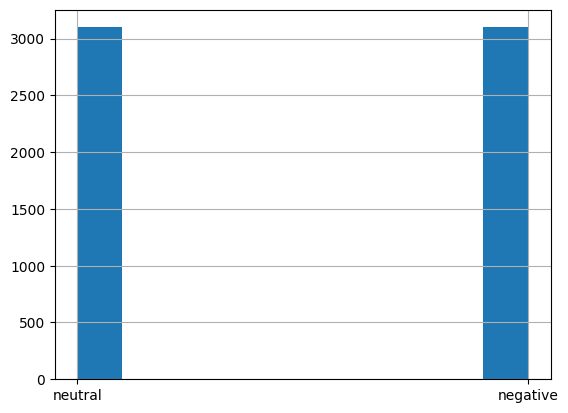

In [13]:
balanced_dataset_df['airline_sentiment'].hist()

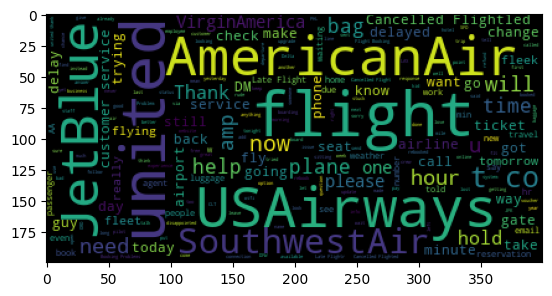

In [16]:
from wordcloud import WordCloud

text = " ".join(balanced_dataset_df['text'].values)
wordcloud = WordCloud(max_font_size=50).generate(text)

plt.imshow(wordcloud)
plt.show()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(balanced_dataset_df['text'].values)

In [19]:
print(len(vectorizer.get_feature_names()))

9238


/Users/donsdai/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()

training_df = balanced_dataset_df.copy()
y = training_df['airline_sentiment']
y = label_encoder.fit_transform(y.astype('str'))
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.33, random_state=1)

In [23]:
print(X_train.shape)
print(y_train.shape)

(4152, 9238)
(4152,)


In [25]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7823, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=7823)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_logistic_regression = logistic_regression.predict(X_test)
print(confusion_matrix(y_test, y_pred_logistic_regression))
print(classification_report(y_test, y_pred_logistic_regression))
print(accuracy_score(y_test, y_pred_logistic_regression))

[[824 203]
 [179 840]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1027
           1       0.81      0.82      0.81      1019

    accuracy                           0.81      2046
   macro avg       0.81      0.81      0.81      2046
weighted avg       0.81      0.81      0.81      2046

0.8132942326490714
